Get PV correlation means and stds for a power calculation.

In [3]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    # sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sd_paper/analysis_and_figure_code/DataPaths'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
from copy import deepcopy
from tqdm import tqdm

from neuropy import plotting
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.analyses.oscillations import detect_theta_epochs
from neuropy.core.position import Position
from neuropy.core.epoch import Epoch
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten
from neuropy.io import BinarysignalIO

import subjects
from plotters import Plotter, get_nsd_vs_sd_df, add_parametric_extras, stats_to_df, filter_stats_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
group_data_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/Clustering/grpdata")

tc_all = pd.read_csv(group_data_dir / "tc_all.csv", index_col=0)
tc_all

,0,1,2,3,4,5,6,7,8,9,...,92,93,94,95,96,97,98,99,session,grp
0,0.000000,0.000000,0.664043,0.298140,1.202241,0.639808,0.120662,0.020136,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,NSD
1,0.207612,0.012711,0.027668,0.204733,0.090885,0.034121,0.130268,0.080546,0.000000,0.000000,...,0.000000,0.000000,0.235479,0.388540,0.000000,0.000000,0.000000,0.000000e+00,0,NSD
2,1.038062,1.272878,1.153802,1.481709,1.286844,0.946563,0.633890,0.419685,0.720616,0.879570,...,0.580255,0.268528,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,NSD
3,2.906574,2.131475,1.057192,0.486249,0.376315,0.178261,0.123277,0.225562,0.141560,0.000000,...,0.300752,0.565374,1.065125,1.165620,0.000000,0.000000,0.000000,0.000000e+00,0,NSD
4,13.702422,7.676248,5.706135,4.906915,5.382127,8.943502,12.748299,16.544660,17.539733,14.345243,...,0.559006,0.296846,0.358689,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0,NSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
917,0.000000,0.202666,0.264557,0.146939,0.000000,0.000000,0.147529,0.088235,0.024507,0.000000,...,7.706031,15.771429,4.860202,0.057286,0.000000,0.000000,0.000000,0.000000e+00,7,SD
918,2.101167,0.153854,0.195986,0.319734,0.778995,0.995184,1.200739,1.676471,1.105364,2.749186,...,1.294102,9.959184,6.867298,3.100058,6.270836,4.988732,1.415816,0.000000e+00,7,SD
919,0.000000,0.146437,0.000000,0.000000,0.107591,0.092978,0.000000,0.000000,0.185730,0.109684,...,0.000000,0.000000,0.000000,1.004710,0.250683,0.000000,0.000000,0.000000e+00,7,SD
920,1.400778,3.562097,4.106440,3.507618,3.904169,5.688379,2.861642,2.470588,1.897298,0.966948,...,0.000000,0.000000,0.000000,0.000000,0.716775,5.439288,0.918367,-4.440892e-16,7,SD


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: inv

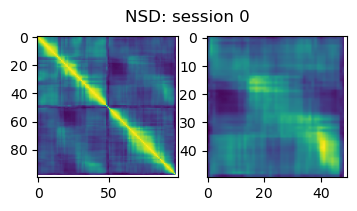

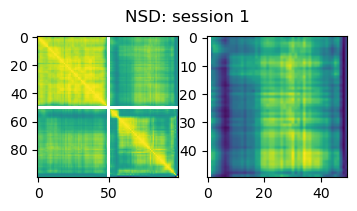

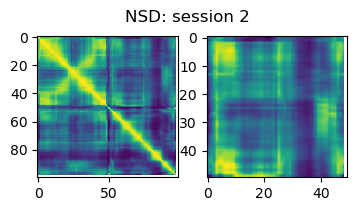

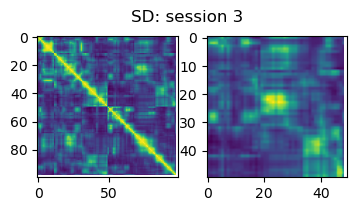

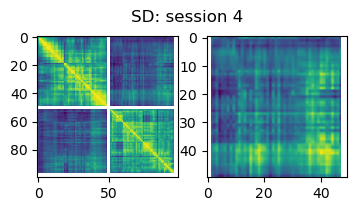

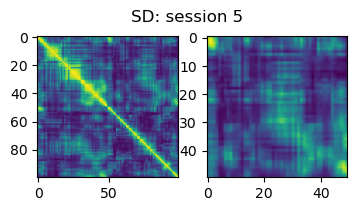

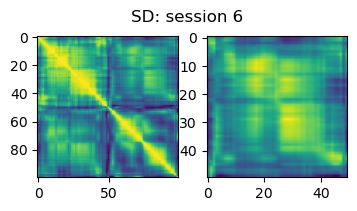

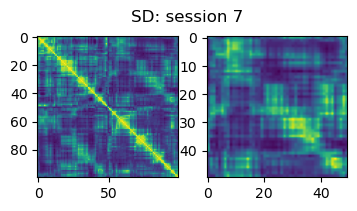

In [42]:
nbins_per_sesh = 50

corrs_diag_df = []
for grp in ["NSD", "SD"]:
    tc_grp = tc_all[tc_all.grp == grp]
    
    for sid in tc_grp.session.unique():
        fig, ax = plt.subplots(1, 2, figsize=(4, 2))
        tc_sesh = tc_grp[tc_grp.session == sid]
        corr_array = np.corrcoef(tc_sesh.drop(columns=["session", "grp"]).to_numpy().T)
        ax[0].imshow(corr_array)
        corr_maze_rmaze = corr_array[0:nbins_per_sesh, nbins_per_sesh:]
        ax[1].imshow(corr_maze_rmaze)
        fig.suptitle(f"{grp}: session {sid}")
        # corrs_diag.append(corr_maze_rmaze[np.eye(50, dtype=bool)])
        tc_df = pd.DataFrame(corr_maze_rmaze[np.eye(50, dtype=bool)][None, :], index=[sid])
        tc_df["session"] = sid
        tc_df["grp"] = grp
        
        corrs_diag_df.append(tc_df)

corrs_diag_df = pd.concat(corrs_diag_df, axis=0)

In [46]:
corrs_diag_df[corrs_diag_df.grp == "NSD"].drop(columns=["grp", "session"]).to_numpy().reshape(1, -1).shape

(1, 150)

In [49]:
corrs_diag_df

,0,1,2,3,4,5,6,7,8,9,...,42,43,44,45,46,47,48,49,session,grp
0,0.081611,0.312758,0.242561,0.256832,0.207299,0.186106,0.158263,0.155613,0.193288,0.255962,...,0.478497,0.467533,0.490474,0.431610,0.392443,0.111387,0.019256,NaN,0,NSD
1,NaN,0.387600,0.406432,0.425032,0.370060,0.279667,0.135674,0.174426,0.292059,0.346309,...,0.541963,0.443707,0.359154,0.451527,0.400407,0.222105,-0.023276,-0.036784,1,NSD
2,0.257738,0.301667,0.534634,0.655975,0.650227,0.655887,0.667569,0.676255,0.628520,0.572481,...,0.221544,0.295681,0.475789,0.467589,0.632943,0.570993,0.406488,NaN,2,NSD
3,0.169585,0.410990,0.664565,0.373925,0.312158,0.344479,0.062491,0.128663,-0.011853,0.006459,...,0.405506,0.160623,0.243828,0.380525,0.637342,0.677748,0.477324,NaN,3,SD
4,NaN,0.203704,0.044514,0.008760,0.124358,0.249384,0.221041,0.120451,0.194351,0.178472,...,0.576843,0.548890,0.408803,0.330215,0.286518,0.387327,NaN,NaN,4,SD
5,0.759874,0.877770,0.765170,0.485854,0.318750,0.319305,0.204704,0.074885,0.138985,0.152587,...,0.365925,0.365978,0.347987,0.433707,0.625693,0.548806,0.633447,0.459305,5,SD
6,0.507473,0.585491,0.675486,0.388697,0.421766,0.390227,0.595952,0.603507,0.663657,0.677539,...,0.633302,0.643694,0.638022,0.641513,0.322376,0.317911,0.206937,0.010565,6,SD
7,0.079723,0.070165,0.204733,0.184984,0.296590,0.239655,0.446578,0.521777,0.295406,0.351989,...,0.430808,0.417167,0.663252,0.605338,0.554571,0.284780,0.398000,-0.046288,7,SD


In [60]:
PV_mean = corrs_diag_df.groupby(["grp", "session"]).apply(lambda x: np.mean(x, axis=1)).reset_index().drop(columns="level_2").rename(columns={0: "PVmean"})

/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3502: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [67]:
PV_mean.std()

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_44884/473738146.py:1: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  PV_mean.std()


session    2.449490
PVmean     0.121238
dtype: float64

In [77]:
PV_mean.drop(columns="session").mean().values[0]

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_44884/295898178.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  PV_mean.drop(columns="session").mean().values[0]


0.4360295978441489

In [78]:
sesh_mean = PV_mean.drop(columns="session").mean().values[0]
sesh_std = PV_mean.drop(columns="session").std().values[0]

/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_44884/902286758.py:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sesh_mean = PV_mean.drop(columns="session").mean().values[0]
/var/folders/7g/v7xwy2z52hxcjg7pfsxbb8zc0000gn/T/ipykernel_44884/902286758.py:2: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  sesh_std = PV_mean.drop(columns="session").std().values[0]


In [83]:
stats.ttest_ind_from_stats(sesh_mean, sesh_std, 8, sesh_mean - 0.13, sesh_std, 8)

Ttest_indResult(statistic=2.1445501941531804, pvalue=0.0500220137389714)

In [88]:
stats.ttest_ind(PV_mean[PV_mean.grp == "NSD"].PVmean.values - 0.13, PV_mean[PV_mean.grp == "SD"].PVmean.values)

TtestResult(statistic=-2.5393415659587233, pvalue=0.044120074827197445, df=6.0)

<Axes: xlabel='grp', ylabel='PVmean'>

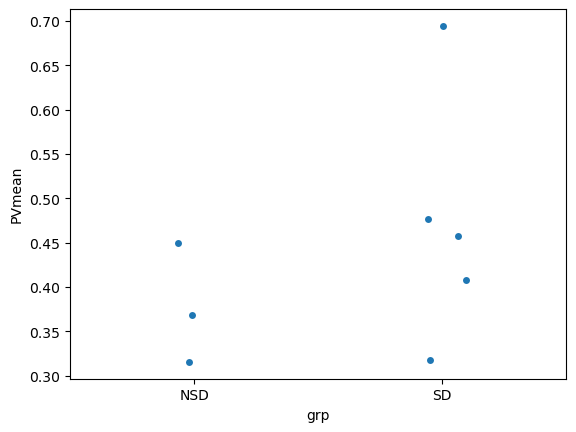

In [89]:
_, ax = plt.subplots()
sns.stripplot(data=PV_mean, x="grp", y="PVmean", dodge=True, ax=ax)

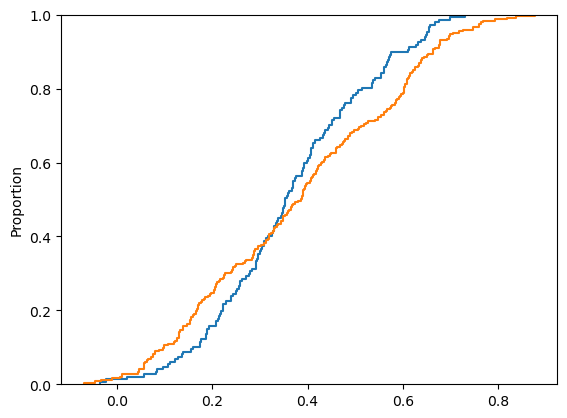

In [48]:
_, ax = plt.subplots()
for grp in ["NSD", "SD"]:
    sns.ecdfplot(data=corrs_diag_df[corrs_diag_df.grp == grp].drop(columns=["grp", "session"]).to_numpy().reshape(1, -1).squeeze(), ax=ax)